You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Epoch 1/100
2s - loss: 0.0352
Epoch 2/100
2s - loss: 0.0133
Epoch 3/100
2s - loss: 0.0110
Epoch 4/100
2s - loss: 0.0098
Epoch 5/100
2s - loss: 0.0084
Epoch 6/100
2s - loss: 0.0072
Epoch 7/100
2s - loss: 0.0062
Epoch 8/100
2s - loss: 0.0054
Epoch 9/100
2s - loss: 0.0048
Epoch 10/100
2s - loss: 0.0044
Epoch 11/100
2s - loss: 0.0042
Epoch 12/100
2s - loss: 0.0040
Epoch 13/100
2s - loss: 0.0039
Epoch 14/100
2s - loss: 0.0038
Epoch 15/100
2s - loss: 0.0039
Epoch 16/100
2s - loss: 0.0038
Epoch 17/100
2s - loss: 0.0038
Epoch 18/100
2s - loss: 0.0037
Epoch 19/100
2s - loss: 0.0038
Epoch 20/100
2s - loss: 0.0037
Epoch 21/100
2s - loss: 0.0037
Epoch 22/100
2s - loss: 0.0037
Epoch 23/100
2s - loss: 0.0037
Epoch 24/100
2s - loss: 0.0036
Epoch 25/100
2s - loss: 0.0035
Epoch 26/100
2s - loss: 0.0035
Epoch 27/100
2s - loss: 0.0036
Epoch 28/100
2s - loss: 0.0035
Epoch 29/100
2s - loss: 0.0035
Epoch 30/100
2s - loss: 0.0036
Epoch 31/100
2s - loss: 0.0035
Epoch 32/100
2s - loss: 0.0035
Epoch 33/100
2s -

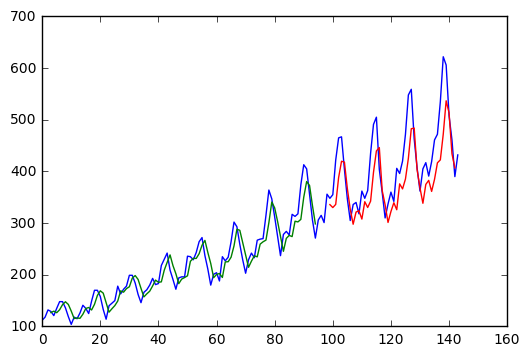

In [1]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()